In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
 'OD280/OD315 of diluted wines', 'Proline']

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
# This is the true test set. The split inside the sequential backward selection is for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

The eigenvalues are [4.68272277 2.5174937  1.44251124 0.95025687 0.91388156 0.70002767
 0.59696802 0.09544816 0.14241154 0.31659155 0.22087117 0.26741076
 0.25909606].
Explained ratio of variances are: [0.35730453 0.19209164 0.11006755 0.07250719 0.06973166 0.05341402
 0.04555029 0.00728295 0.01086639 0.0241568  0.01685307 0.02040417
 0.01976974]


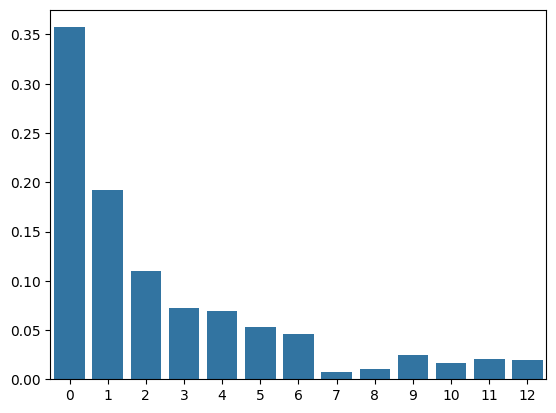

In [3]:
# To do PCA, we have to compute Cov(X^T, X^T) and eigendecompose it
# Since it is a symmetric positive semi-definite matrix, it is guaranteed real eigenvectors and values
cov_mat = np.cov(X_train_std.T)
eigenvals, eigenvecs = np.linalg.eig(cov_mat)

print(f"The eigenvalues are {eigenvals}.")

total_var = np.sum(eigenvals)
print(f"Explained ratio of variances are: {eigenvals/total_var}")

sns.barplot(eigenvals/total_var)
plt.show()

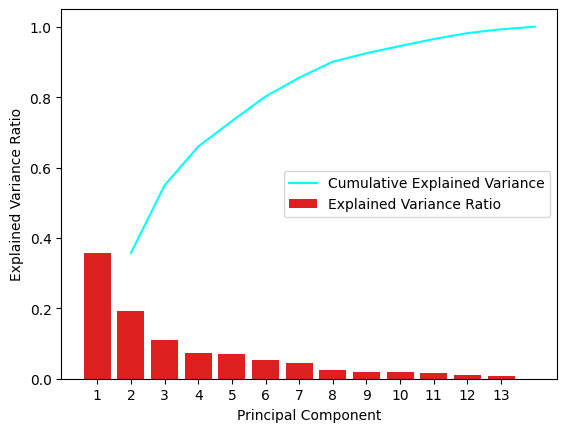

In [4]:
total_var = np.sum(eigenvals)
variance_explained = [(e / total_var) for e in sorted(eigenvals, reverse=True)]
cumulative_explained = np.cumsum(variance_explained)

sns.barplot(x=range(1, len(eigenvals) + 1), y=variance_explained, label="Explained Variance Ratio", color='red')
sns.lineplot(x=range(1, len(eigenvals) + 1), y=cumulative_explained, label="Cumulative Explained Variance", color='cyan')
plt.xlabel('Principal Component')
plt.ylabel("Explained Variance Ratio")
plt.legend(loc='best')
plt.show()

In [5]:
eigenpairs = [(eigenvals[i], eigenvecs[:, i]) for i in range(len(eigenvals))]
eigenpairs.sort(key=lambda p: p[0], reverse=True)

num_p_components = 2
W = np.hstack([eigenpairs[i][1][:, np.newaxis] for i in range(num_p_components)])
print("We have now build our projection matrix, W.")
print(W)

We have now build our projection matrix, W.
[[ 0.15763477  0.49414675]
 [-0.25237011  0.1670862 ]
 [-0.01662626  0.33581955]
 [-0.23514225 -0.0230456 ]
 [ 0.14285062  0.2816766 ]
 [ 0.38989121  0.07164769]
 [ 0.42596901  0.00569565]
 [-0.28675917  0.04855187]
 [ 0.30864294  0.00589032]
 [-0.08886736  0.52633004]
 [ 0.30119689 -0.28399523]
 [ 0.37783572 -0.18136641]
 [ 0.28836287  0.3703045 ]]


In [6]:
X_train_pca = X_train_std @ W
X_test_pca = X_test_std @ W

In [7]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1).fit(X_train_pca, y_train)
print(f"The 2 component PCA training score is {knn.score(X_train_pca, y_train) * 100: .2f}%.")
print(f"The 2 component PCA test score is {knn.score(X_test_pca, y_test) * 100: .2f}%.")

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1).fit(X_train_std, y_train)
print(f"The all inclusive training score is {knn.score(X_train_std, y_train) * 100: .2f}%.")
print(f"The all inclusive test score is {knn.score(X_test_std, y_test) * 100: .2f}%.")

The 2 component PCA training score is  97.58%.
The 2 component PCA test score is  94.44%.
The all inclusive training score is  98.39%.
The all inclusive test score is  94.44%.


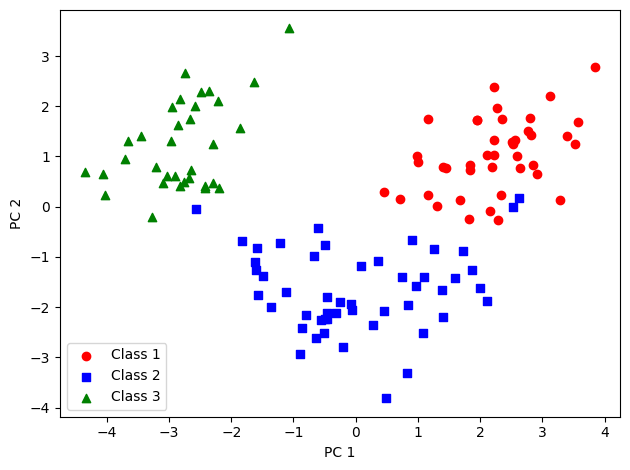

In [8]:
# It is useful to see how the target variables get organized with respect to the Principal Components
# However, recall that there are no labels necessary to do a PCA - it is completely unsupervised
# This is just for illustrative purposes

colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(
        X_train_pca[y_train == l, 0],
        X_train_pca[y_train == l, 1],
        c=c, label=f'Class {l}', marker=m
    )

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [12]:
# We can also do PCA with scikit learn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)


X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=42, solver='lbfgs').fit(X_train_pca, y_train)

print(f"Training score: {lr.score(X_train_pca, y_train) * 100:.2f}%.")
print(f"Test score: {lr.score(X_test_pca, y_test) * 100:.2f}%.")

Training score: 97.58%.
Test score: 94.44%.


c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


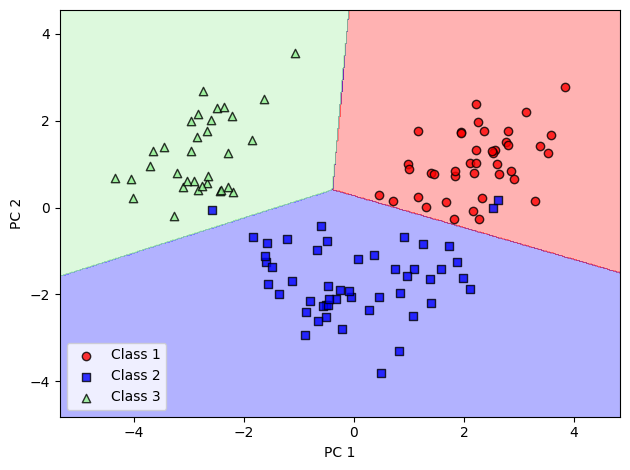

In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
        y=X[y == cl, 1],
        alpha=0.8,
        c=colors[idx],
        marker=markers[idx],
        label=f'Class {cl}',
        edgecolor='black')


plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [ ]:
# If you want the explained variance ratio instead, we can fit to keep all PCA components

pca = PCA(n_components=None) # Keeps all components  
X_train_pca_all = pca.fit_transform(X_train_std)
print(pca.explained_variance_ratio_)

[0.35730453 0.19209164 0.11006755 0.07250719 0.06973166 0.05341402
 0.04555029 0.0241568  0.02040417 0.01976974 0.01685307 0.01086639
 0.00728295]


PCA usually results in normalize eigensystems. Since the covariance matrix $\Sigma = \mathrm{Cov(X^T)}$ is s.p.d, we create the eigenvectors through $\Sigma = P D P^T$. The Loadings are scaled eigenvectors $\sqrt{D} P$, which carry information about the relevance of each direction in component space. Here $\sqrt{D}$ is understood as the natural square root, done component-wise.

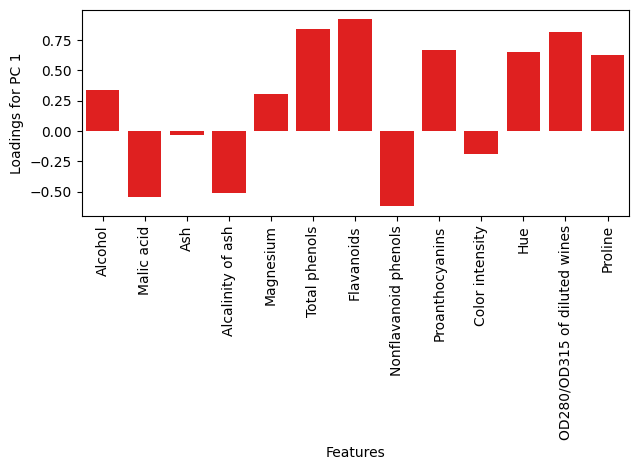

In [37]:
loadings = eigenvecs * np.sqrt(eigenvals)
# Or through sklearn
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
component_index = 0

ax = sns.barplot(loadings[:, 0], color='red')
ax.set_xticks(range(X.shape[1]))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)
plt.xlabel('Features')
plt.ylabel(f'Loadings for PC {component_index + 1}')
plt.tight_layout()
plt.show()